# Маркетинговая аналитика приложения Procrastinate Pro+

Несколько последних месяцев компания-разработчик развлекательного приложения `Procrastinate Pro+` терпит убытки, несмотря на огромные вложения в рекламу. Наша задача как маркетинговых аналитиков — разобраться в причинах и помочь компании выйти в плюс.

Для исследования предоставлены следующие данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Цели исследования:**

- определить, откуда приходят пользователи и какими устройствами они пользуются
- рассчитать стоимость привлечения пользователей из различных рекламных каналов
- узнать, сколько денег приносит каждый клиент
- определить, когда расходы на привлечение клиента окупаются
- выявить факторы, которые мешают привлечению клиентов

**Ход исследования:**

Исходные данные прочитаем из CSV-файлов:

- визиты: `/datasets/visits_info_short.csv`,
- заказы: `/datasets/orders_info_short.csv`,
- расходы: `/datasets/costs_info_short.csv`.

Для проведения исследования необходимо изучить и подготовить исходные данные к анализу. Для начала проведем предобработку данных: проверим данные на пропуски, выбросы, наличие дубликатов, корректность типов данных, по возможности устраним и обработаем обнаруженные проблемы. Далее соберем необходимые функции для вычисления значений метрик, а также ряд функций для построения графиков. На этапе исследовательского анализа составим профили пользователей и определим, из каких стран они приходят. Также выявим предпочтения пользователей по типам устройства и рекламным каналам. В ходе исследования посчитаем общую сумму расходов на маркетинг и ознакомимся с распределением трат по рекламным источникам. На этапе оценки окупаемости рекламы, используя кривые `LTV`, `ROI` и `CAC`, а также графики конверсии и удержания, проанализируем и оценим как общую окупаемость рекламы, так и ее эффективность с разбивкой по доступным характеристикам пользователей — типу устройства, стране, каналу привлечения. На заключительном этапе обозначим возможные причины неэффективности привлечения пользователей и сформулируем рекомендации для отдела маркетинга.

**Основные этапы исследования:**

1. Изучение и предобработка данных.
2. Задание функций для расчёта и анализа `LTV`, `ROI`, удержания и конверсии.
3. Проведение исследовательского анализа данных.
4. Анализ маркетинговых затрат.
5. Оценка окупаемости рекламы.
6. Составление общего вывода.

### Изучение данных и подготовка их к анализу

Импортируем библиотеки, которые будем использовать для проведения исследовательской работы.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib
import matplotlib.pyplot as plt

Для ознакомления с исходными данными загрузим информацию о визитах, заказах и рекламных расходах из CSV-файлов в переменные `visits`, `orders` и `costs`.

In [2]:
# загрузка исходных данных о визитах, заказах и рекламных расходах.
try:
    visits, orders, costs = (pd.read_csv('/datasets/visits_info_short.csv'),
                             pd.read_csv('/datasets/orders_info_short.csv'),
                             pd.read_csv('/datasets/costs_info_short.csv'))
except:
    visits, orders, costs = (pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv'),
                             pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv'),
                             pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv'))

Выведем первые строки и основную информацию для каждого датафрейма, а также посчитаем количество строк дубликатов и проверим данные на наличие пропусков.

In [3]:
df_name = visits, orders, costs # Названия всех датафреймов
for df in df_name:
    display(df.head()) # Первые строки таблицы
    print()
    df.info() # Основная информация 
    print()
    print('Количество строк дубликатов:', df.duplicated().sum()) # Количество дубликатов
    print('Количество пропущенных значений:')
    print(df.isna().sum()) # Количество пропусков

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

Количество строк дубликатов: 0
Количество пропущенных значений:
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

Количество строк дубликатов: 0
Количество пропущенных значений:
User Id     0
Event Dt    0
Revenue     0
dtype: int64


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB

Количество строк дубликатов: 0
Количество пропущенных значений:
dt         0
Channel    0
costs      0
dtype: int64


Таблица с данными о визитах хранит лог сервера с информацией о посещениях сайта. В ней всего 6 столбцов и 309 901 строк.

**Описание данных таблицы `visits`:**
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

Данные о заказах представлены таблицей из 3 столбцов и 40 212 строк.

**Описание данных таблицы `orders`:**
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

Датафрейм с расходами на рекламу состоит также из 3 столбцов, но количество строк значительно меньше - 1 800.

**Описание данных таблицы `costs`:**
- `dt` — дата проведения рекламной кампании,
- `Channel` — идентификатор рекламного источника,
- `costs` — расходы на эту кампанию.

Отметим, что в полученных данных каждой таблицы отсутствуют пропущенные значения и строки дубликаты. Убедились, что типы данных во всех колонках соответствуют сохранённым в них значениям, за исключением столбцов с датой и временем.

Также необходимо привести названия столбцов в соответствие с хорошим стилем. Для этого заменим пробелы нижним подчеркиванием и оставим наименоваия в нижнем регистре, а также проверим корректность изменений.

In [4]:
# Приведение наименований столбцов в соответствие с хорошим стилем
for df in df_name:
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    print(df.columns) # Проверка корректности изменений

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


Для дальнейшего анализа приведем столбцы с датой и временем в каждом датафрейме к соответствующему типу данных и убедимся в корректности изменений. Для этого столбцы с датой и временем начала и окончания сессии, а также данные с датой и временем покупки приведем к типу даты и времени. А дату проведения рекламной кампании приведем к типу даты.

In [5]:
# Приведение данных с датой и временем к соответствующему типу данных
for df in visits, orders:
    for col in df.columns:
        if 'dt' in col or 'session' in col:
            df[col] = pd.to_datetime(df[col])
            print(f'{df[col].name}: {df[col].dtype}') # Проверка корректности изменений
            
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

session_start: datetime64[ns]
session_end: datetime64[ns]
event_dt: datetime64[ns]


Проверим категориальные значения на наличие неявных дубликатов. Для этого отсортируем и выведем уникальные значения стран и типов устройства пользователя, а также идентификаторов источника перехода из таблицы с данными о визитах и идентификаторов рекламного источника из датафрейма с информацией о расходах на рекламу.

In [6]:
col_list = ['region', 'device', 'channel'] # Список с названиями столбцов
# Вывод уникальных значений категориальных данных
for df in df_name:
    for col in col_list:
        if col in df.columns:
            print(col,'-', df[col].sort_values().unique())
            print()

region - ['France' 'Germany' 'UK' 'United States']

device - ['Android' 'Mac' 'PC' 'iPhone']

channel - ['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']

channel - ['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds']



Убедились, что неявных дубликатов в исходных данных нет. Проверим, нет ли выбивающихся или подозрительных значений в столбцах с числовым типом данных. Для этого ознакомимся со статистическими характеристиками сумм заказа из `orders` и расходов на рекламную кампанию в `costs`.

In [7]:
# Статистические данные по числовым столбцам 
pd.options.display.float_format = '{:.2f}'.format
display(orders.revenue.describe())
display(costs.costs.describe())

count   40212.00
mean        5.37
std         3.45
min         4.99
25%         4.99
50%         4.99
75%         4.99
max        49.99
Name: revenue, dtype: float64

count   1800.00
mean      58.61
std      107.74
min        0.80
25%        6.50
50%       12.29
75%       33.60
max      630.00
Name: costs, dtype: float64

Проверили, что в столбцах с суммой заказа и расходами на рекламную кампанию нет отрицательных и нулевых значений. Средние и медианные значения выручки близки, чего нельзя сказать про расходы на рекламу. Но так как рекламный бюджет зависит от большого количества факторов, у каждой отдельной рекламной кампании состав рекламного бюджета и расходуемые суммы могут значительно отличаться.

**Вывод**

На этапе знакомства с данными изучили общую информацию о визитах, заказах и рекламных расходах. В ходе ознакомления с данными пропущенные, аномальные значения и дубликаты не обнаружены. В процессе проверки типов данных на соответствие сохранённым в них значениям, обнаружили некорректный тип в столбцах с датой и временем, обработкой которого занялись на этапе подготовки данных к анализу. Также привели названия столбцов в соответсвие с хорошим стилем. Таким образом, этап изучения общей информации и предобработки данных заверешен, данные изучены и подготовлены к дальнейшему анализу.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

#### Функции для вычисления значений метрик.

Для вычисления значений метрик напишем следующие функции:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

**Функция для создания профилей пользователей - `get_profiles()`**

Готовые профили пользователей значительно упрощают дальнейший анализ. Для создания пользовательских профилей напишем функцию `get_profiles()`.

In [8]:
# функция для получения пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    
    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим параметры первых посещений
    # столбец с временем первого посещения назовём first_ts
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index() # возвращаем user_id из индекса
    )
    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    
    # считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index() # возвращаем dt и channel из индексов
    )
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles # возвращаем профили с CAC

**Функция для подсчёта Retention Rate - `get_retention()`**

Один из главных критериев «качества» пользователей — как долго клиент остаётся с компанией. На языке метрик этот факт часто описывают показателем `Retention Rate`. Данный  коэффициент показывает, сколько пользователей из когорты относительно их изначального числа вернулись, то есть воспользовались продуктом или услугой, в последующие периоды. Чтобы рассчитать коэффициент удержания, количество активных пользователей на текущий день делят на количество активных пользователей на первый день.

Напишем функцию для подсчёта `Retention Rate`.

In [9]:
# функция для расчета удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    
    # вычисляем лайфтайм каждой сессии в днях
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу удержания
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим данные таблицы удержания на размеры когорт
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем столбец с размерами когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем сырые данные, таблицу удержания и таблицу динамики удержания
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта конверсии - `get_conversion()`**

Применительно к когортному анализу конверсия, или коэффициент конверсии (CR), — это процент пользователей когорты, совершивших какое-нибудь действие. Чаще всего считают главную для бизнеса конверсию — из неплатящих пользователей в платящие. Чем выше процент покупателей в когортах, тем лучше для компании. Чтобы узнать `Conversion Rate`, накопленное количество новых покупателей на текущий лайфтайм делят на размер когорты, то есть количество активных пользователей на первый день.

Напишем функцию для подсчёта конверсии - `get_conversion()`.

In [10]:
# функция для расчета конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем столбец с размерами когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для подсчёта LTV и ROI - `get_ltv()`**

Чтобы включить в анализ повторные покупки, считают экономику одного покупателя. Три самые важные метрики в этом методе — `LTV`, `CAC` и `ROI`.

`LTV`, или Lifetime Value, — это «пожизненная ценность» клиента, то есть общая сумма денег, которую один клиент в среднем приносит компании со всех своих покупок. В рамках когортного анализа для расчёта `LTV` выручку с накоплением за текущий день делят на размер когорты, то есть количество активных пользователей на первый день.

`CAC`, или Customer Acquisition Cost, — стоимость привлечения одного клиента. Сумма денег, в которую компании обходится каждый новый клиент. В сущности, `CAC` — это инвестиции в маркетинг. Для рассчета стоимости привлечения новых пользователей рекламные расходы делят на размеры когорт.

`ROI`, или Return On Investment, — окупаемость инвестиций. В экономике одного покупателя эта метрика показывает, на сколько процентов `LTV` превысил `CAC`. Ещё говорят: на сколько процентов «окупились» клиенты. В когортном анализе `ROI` рассчитывают делением `LTV` на `CAC`. `ROI = LTV / CAC` = (Выручка от рекламной кампании / Размер когорты) / (Затраты на рекламу / Размер когорты) = Выручка от рекламной кампании / Затраты на рекламу.

Для дальнейшего анализа напишем функцию `def get_ltv()` для расчёта `LTV` и `ROI`.

In [11]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
     # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        
        # собираем датафрейм с данными пользователей и значениями CAC, добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        
        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)
        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes
        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']
        # в финальной таблице оставляем размеры когорт, CAC и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        # возвращаем таблицы LTV и ROI
        return result, roi
    
    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    
    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

####  Функции для построения графиков.

Воспользуемся следующими функциями для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi()` — для визуализации LTV и ROI.

**Функция для сглаживания данных - `filter_data()`**

Напишем функцию `filter_data()` для сглаживания фрейма. Отметим, что чем шире окно сглаживания, тем меньше шума на графике. 

In [12]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция для построения графика Retention Rate - `plot_retention()`**

Напишем функцию для визуализации удержания — `plot_retention()`. Результатом её вызова будут четыре графика: кривые и динамика удержания с разделением на платящих и неплатящих пользователей.

In [13]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer, добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция для построения графика конверсии - `plot_conversion()`**

Напишем аналогичную функцию и для визуализации конверсии — `plot_conversion()`. Результатом её вызова будут два графика: кривые и динамика конверсии. Разделение на платящих и неплатящих пользователей в контексте конверсии не имеет смысла.

In [14]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для визуализации LTV и ROI - `plot_ltv_roi()`**

Наконец, напишем функцию для визуализации пожизненной ценности и окупаемости — `plot_ltv_roi()`. Она немного сложнее предыдущих, потому что включает больше метрик.
Результатом вызова функции станут:

- кривые LTV,
- кривые ROI,
- график истории изменений LTV,
- график истории изменений ROI,
- график истории изменений CAC.

Графики, отражающие динамику метрик, сгладим функцией `filter_data()`.

In [15]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод**

Для проведения корректного исследовательского анализа данных собрали следующие функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Для для построения графиков будем испоьзовать функции:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi()` — для визуализации LTV и ROI.

### Исследовательский анализ данных

На этапе исследовательского анализа данных составим профили пользователей и определим временной диапазон их привлечения. Далее выясним, из каких стран пользователи приходят в приложение, и на какую страну приходится больше всего платящих пользователей. Также на данном этапе исследования узнаем, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи. На заключительном шаге данного этапа изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.

- **Составление пользовательских профилей и определение даты привлечения.**

Составим профили пользователей и выведем первые строки. Определим минимальную и максимальную даты привлечения пользователей.

In [16]:
# получение пользовательских профилей
events = []
profiles = get_profiles(visits, orders, events, costs, event_names=[])
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


In [17]:
# определение минимальной и максимальной даты привлечения пользователей
print('Минимальная дата привлечения пользователей:',profiles['dt'].min())
print('Максимальная дата привлечения пользователей:',profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Таким образом, убедились в корректности технического задания, профили содержат данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.

- **Распределение пользователей по странам.**

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Для этого напишем функцию отображения распределения пользователей по параметру и построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [18]:
# напишем функцию для распределения пользователей по параметру
def distribution(region):

    # построим таблицу, отражающую количество пользователей и долю платящих из каждой страны
    new_profiles = profiles.groupby(region).agg({'user_id': 'nunique', 'payer':['sum', 'mean']})
    # переименуем названия столбцов и выведем долю в %
    new_profiles.columns = ['all_count', 'payer_count', 'payer_ratio']
    new_profiles.payer_ratio = new_profiles.payer_ratio.apply(lambda x: format(x,'.2%'))
    return(new_profiles.sort_values('payer_ratio', ascending=False))
display(distribution(profiles['region']))

,all_count,payer_count,payer_ratio
region,,,
United States,100002,6902,6.90%
Germany,14981,616,4.11%
UK,17575,700,3.98%
France,17450,663,3.80%


Абсолютным лидером по общему количеству пользователей, числу платящих, а также по доле платящих пользователей является США. Однако, доля платящих клиентов не достигает и 7 % от общего числа пользователей страны. На втором месте по доле платящих - Германия, несмторя на минимальное количество всех пользователей. Третье и четвертое место у Великобритании и Франции, разрыв в доле платящих пользователей этих стран незначительный.

- **Распределение пользователей по типу устройства.**

Узнаем, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи. Для этого воспользуемся функцией `distribution()` и построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [19]:
# таблица, отражающая количество пользователей и долю платящих для каждого устройства
display(distribution(profiles['device']))

,all_count,payer_count,payer_ratio
device,,,
Mac,30042,1912,6.36%
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%


Наибольшая часть пользователей заходит с `iPhone`, менее популярны `PC` и `Mac`. Неожиданно по доле платящих пользователей в лидеры вырывается тот же `Mac`, а наименьшая конверсия в платящих пользователей у `Andriod` и `PC`.

- **Распределение пользователей по каналам привлечения.**

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Для этого передадим в качестве аргумента идентификаторы источника перехода в функцию `distribution()` и построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [20]:
# таблица, отражающая количество пользователей и долю платящих для канала привлечения
display(distribution(profiles['channel']))

,all_count,payer_count,payer_ratio
channel,,,
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
WahooNetBanner,8553,453,5.30%
YRabbit,4312,165,3.83%
MediaTornado,4364,156,3.57%
LeapBob,8553,262,3.06%
OppleCreativeMedia,8605,233,2.71%
organic,56439,1160,2.06%
FaceBoom,29144,3557,12.20%


Изучив таблицу, отметим, что наибольшая доля пользователей приходит естественным путем, однако у этих пользователей минимальная конверсия в платящих. Самыми популярными каналами привлечения являются `FaceBoom` и `TipTop`, они же и находятся в лидерах по доле платящих пользователей. Также высокая конверсия в плятящих пользователей у `lambdaMediaAds` и `AdNonSense`, несмотря на минимальное количество пользователей данных каналов привлечения.

**Вывод**

В ходе исследовательского анализа данных составили пользователтские профили, и убедились в корректности временного диапазона привлечения клиентов, обозначенного в техническом задании. Пользователи привлекались с 1 мая по 27 октября 2019 года.

Определили, что пользователи приходят в приложение `Procrastinate Pro+` преимущественно из США, конверсия в платящих клиентов у этой страны также превосходит другие страны. Несмотря на минимальное количество клиентов из Германии, по доле платящих пользователей страна занимает второе место. Также пользователи приходят в приложение из Великобритании и Франции, доля платящих клиентов этих стран немного ниже.

В процессе исследования устройств пользователей, определили, что большая часть клиентов заходит с мобильных устройств, в частности с `iPhone`. Конверсия в платящих пользователей у данного типа устройства уступает лишь `Mac`, у которого число пользователей, напротив, минимальное. Также пользователи заходят в приложении с `Andriod` и `PC`, у которых доля платящих пользователей меньше.

На заключительном шаге данного этапа изучили рекламные источники привлечения и определили каналы, из которых пришло больше всего платящих пользователей. Большая часть клиентов приходит естественным путем, но такие пользователи реже становятся платящими. Наиболее популярными рекламными каналами являются `FaceBoom` и `TipTop`, конверсия в платящих клиентов данных источников высока. Также к лидерам по доле платящих пользователей отнесли `AdNonSense` и `lambdaMediaAds`, несмотря на минимальное количество пользователей. Возможно, имеет смысл обратить внимание на эти источники и увеличить размер рекламных бюджетов по ним.

### Маркетинг

На этапе анализа маркетинга рассчитаем общую сумму расходов на рекламу. Далее отобразим распределение трат по рекламным источникам и определим размер вливаний средств в каждый канал. Также визуализируем динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику. И на заключительном шаге данного этапа узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника.

- **Общая сумма расходов на маркетинг.**

Рассчитаем общую сумму расходов на маркетинг.

In [21]:
# общая сумма расходов на маркетинг
round(profiles['acquisition_cost'].sum(), 2)

105497.3

Общая сумма расходов на маркетинг приложения `Procrastinate Pro+` составила порядка 105,5 тысяч у.е.

- **Распределение трат по рекламным источникам.**

Рассмотрим, как траты распределены по рекламным источникам, и посчитаем, сколько денег потратили на каждый источник.

In [22]:
# распределение трат по рекламным источникам
costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Максимальные рекламные затраты у каналов `TipTop` и `FaceBoom`. Напомним, что данные рекламные источники лидируют по количеству привлеченных пользователей и имеют хорошую конверсию в платящих клиентов, поэтому высокие затраты на их привлечение могут быть оправданы. Минимальные затраты на маркетинг у `MediaTornado` и `YRabbit`, они не превышают 1 тысячи у.е..

- **Динамика изменения расходов во времени по каждому источнику.**

Для визуализации динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику, добавим в таблицу с рекламными расходами два столбца - с номерами месяца и недели даты проведения рекламной кампании.

In [23]:
# добавление новых столбцов в таблицу costs
costs['month_dt'] = pd.to_datetime(costs['dt']).dt.month
costs['week_dt'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

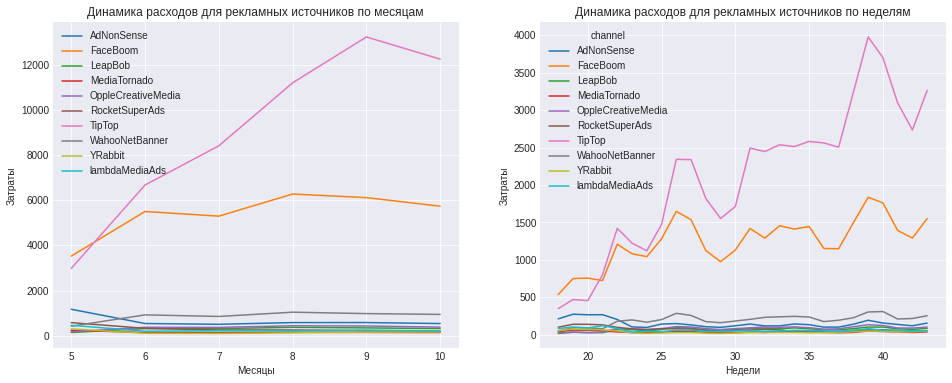

In [24]:
matplotlib.style.use('seaborn-darkgrid')
plt.figure(figsize=(16, 6))
# график динамики затрат по месяцам
ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(index='month_dt', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax = ax1)
plt.legend(loc="upper left")
plt.xlabel('Месяцы')
plt.ylabel('Затраты')
plt.title('Динамика расходов для рекламных источников по месяцам')

# график динамики затрат по неделям
ax2 = plt.subplot(1, 2, 2)
costs.pivot_table(index='week_dt', columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax = ax2)
plt.xlabel('Недели')
plt.ylabel('Затраты')
plt.title('Динамика расходов для рекламных источников по неделям');

С помощью визуализации динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику, также видим, что затраты у `TipTop` и `FaceBoom` значительно превышают рекламный бюджет остальных каналов. 

На графике с динамикой расходов по месяцам прослеживается резкий рост затрат канала `TipTop` с мая по сентябрь, рекламные затраты источника перехода `FaceBoom` плавно увеличивались с мая по август. Также прослеживается небольшой рост рекламных расходов канала `WahooNetBanner`, а у остальных каналов были незначительные измененния стоимости рекламного бюджета.

На графике с динамикой расходов по неделям можно отметить, что для каналов `TipTop` и `FaceBoom` самой дорогой была 39 неделя. Несмотря на общую тенденцию роста затрат данных каналов, от недели к неделе прослеживается различная динамика изменения расходов.

- **Стоимость привлечения пользователя.**

Узнаем, сколько в среднем стоило привлечение одного пользователя (`CAC`) из каждого источника. Для этого воспользуемся профилями пользователей.

In [25]:
# расчет САС по каждому рекламному источнику
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values('acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самое дорогое привлечение пользователя у канала `TipTop` - 2.8 у.е., на втором и третьем местах по величине `САС` источники `FaceBoom` и `AdNonSense`. Дешевле всего привлечение пользователя обходится  в `YRabbit`, `MediaTornado`, `LeapBob`, в указанных источниках `САС` не превышает 0.22 у.е. Распределение `САС` частично совпадает с распределением трат по рекламным источникам, в частности лидирующие позиции `TipTop` и `FaceBoom`, и замыкающие - у рекламных каналов `MediaTornado` и `YRabbit`.

Также произведем расчет среднего `САС` для всех рекламных источников, для этого воспользуемся срезом пользовательских профилей, в котором отфильтруем органических пользователей.

In [26]:
# расчет САС по всем рекламном каналам
print('Средний САС всех рекламных каналов привлечения: {:.3} у.е.'.format(profiles.query('channel != "organic"')\
                                                                  .acquisition_cost.mean()))

Средний САС всех рекламных каналов привлечения: 1.13 у.е.


Отметим, что у двух рекламных источников `FaceBoom` и `AdNonSense` расходы на привлечение одного клиента близки к среднему `САС` по всем рекламным каналам. Затраты на привлечение пользователя из `TipTop` превышают `САС` всех рекламных источников почти в 2,5 раза, а у остальных рекламных каналов, напротив, данный показатель значительно ниже.

**Вывод**

В процессе анализа маркетинговых расходов определили, что общая сумма  рекламных затрат составляет примерно 105, 5 тысяч у.е. Рассмотрели распределение трат по рекламным источникам и выделили два канала - `TipTop` и `FaceBoom`, затраты которых многократно превышают размер рекламного бюджета других каналов привлечения. Также обратили внимание, что у каналов `MediaTornado` и `YRabbit` рекламные затраты настолько малы, что не превышают 1 тысячи у.е.

На этапе маркетингового анализа отразили визуализацию динамики изменения расходов во времени по каждому источнику перехода. На графике с динамикой расходов по месяцам прослеживается резкий рост затрат канала `TipTop` с мая по сентябрь и плавное увеличение рекламных затрат источника `FaceBoom` с мая по август, у остальных каналов были незначительные измененния стоимости рекламного бюджета. На графике динамики рекламных трат по неделям отметили, что для лидеров по рекламным расходам самой дорогой была 39 неделя. Несмотря на общую тенденцию роста затрат данных каналов, от недели к неделе прослеживается различная динамика изменения расходов. 

На заключительном шаге данного этапа определили, сколько в среднем стоило привлечение одного пользователя из каждого источника, и сравнили полученные результаты с `CAC` по всем рекламным каналам. Стоимость привлечения клиента по всем рекламным каналам составляет 1.13 у.е., следовательно, `CAC` канала `TipTop` значительно превышает этот показатель. Возможно, затраты на данный источник перехода завышены, и стоит сократить размер рекламного бюждета. Для других рекламных каналов, напротив, данный показатель не превышает 1 у.е., следует обратить внимание на каналы с низкой стоимостью привлечения пользователя и увеличить вливание средств в их рекламные кампании. На следующем этапе рассчитаем и визуализируем бизнес-показатели, которые помогут сделать верные выводы и дать рекомендации компании.

### Оценка окупаемости рекламы

На данном этапе исследования, используя кривые `LTV`, `ROI` и `CAC`, а также графики конверсии и удержания, проанализируем и оценим как общую окупаемость рекламы, так и ее эффективность с разбивкой по доступным характеристикам пользователей — типу устройства, стране, каналу привлечения. Начнем анализ с определения момента и горизонта анализа данных. 

- **Определение момента и горизонта анализа.**

Используя графики `LTV`, `ROI` и `CAC`, проанализируем окупаемость рекламы в целом. В процессе анализа учтем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно. Также отметим, что нет необходимости включать в анализ органических пользователей, по ним компания не несет маркетинговых затрат. Для корректного анализа зададим момент и горизонт анализа данных, а также отфильтруем пользовательские профили от органических клиентов.

In [27]:
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа

# исключение органических пользователей из профилей
profiles = profiles.query('channel != "organic"') 

#### Графики `LTV`, `ROI` и графики динамики `LTV`, `CAC` и `ROI`.

Проанализируем окупаемость рекламы c помощью графиков `LTV` и `ROI`, а также графиков динамики `LTV`, `CAC` и `ROI`. Получим таблицы `LTV`, `ROI` и их динамики через функцию `get_ltv()`. Визуализируем кривые `LTV`, `ROI`, их динамику, а также динамику `СAC` вызовом функции `plot_ltv_roi()`.

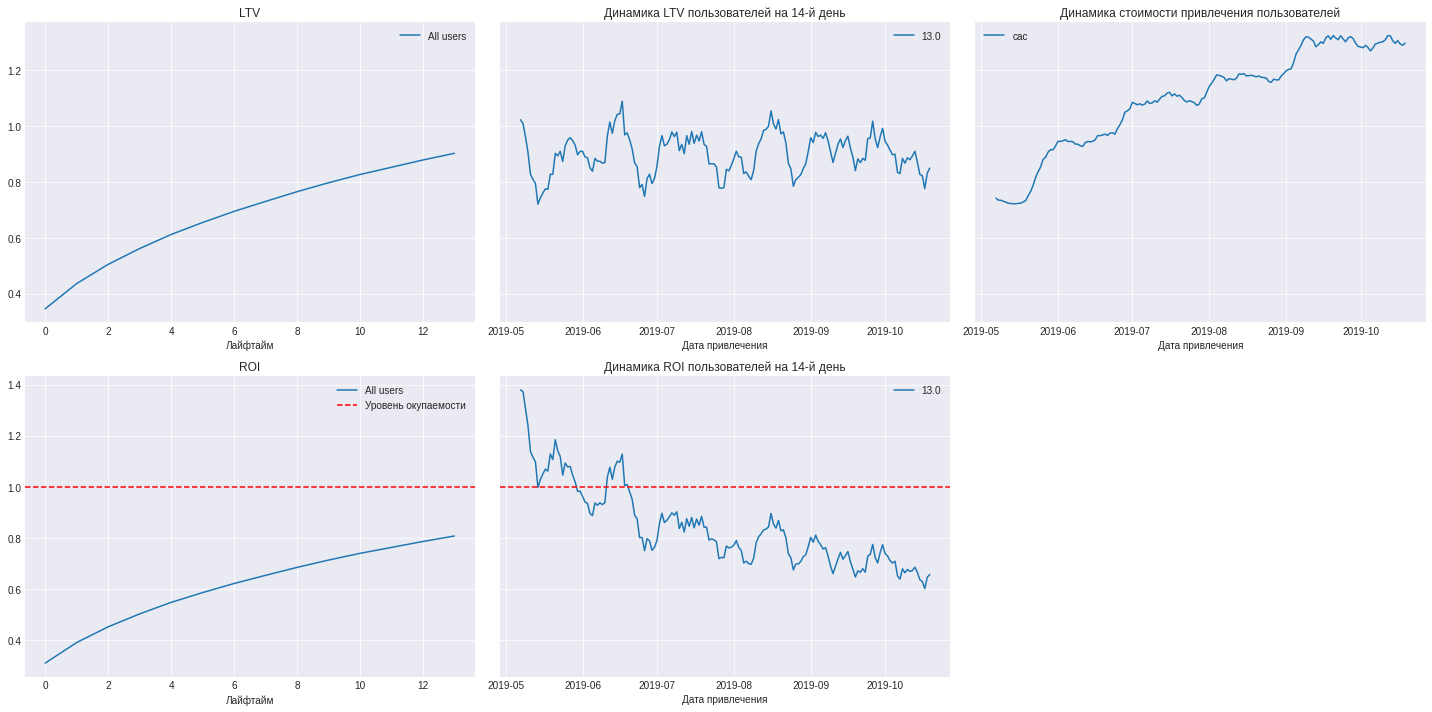

In [28]:
# получение сырых данных, таблицы LTV, таблицы динамики LTV, таблицы ROI, таблицы динамики ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# визуализация кривой ltv, динамики ltv, динамики cac, кривой roi, динамики roi
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод**

Исходя из полученных графиков можем резюмировать следующее:

- Показатель пожизненной ценности клиента достаточно стабилен, но не превосходит `САС`. Для эффективной рекламной кампании `LTV` должен быть выше расходов на привлечение клинта.
- Стоимость привлечения пользователей постоянно увеличивается. Подобное увеличение рекламного бюджета может являться одной из причин неокупаемости рекламы.
- В общем реклама не окупается, так как к концу второй недели `ROI` достигает лишь 0.8.
- Динамика окупаемости рекламы имеет общую тенденцию к снижению на протяжении всего периода, и пользователи перестают окупаться уже в июне.

К общим рекомендациям можно отнести снижение соимости привлечения клиента. Подобному снижению может способствовать оптимизация: ценообразования, расходов на рекламу, воронки продаж. Также стоит позаботиться об увеличении LTV путем оптимизации продукта, повышения лояльности пользователей или, к примеру, за счет увеличения среднего чека.

Таким образом, убедились в том, что несмотря на вложения в рекламу, компания терпит убытки. Чтобы разобраться в причинах неэффектвности маркетинга, проанализируем конверсию и удержание пользователей, а также пройдёмся по всем доступным характеристикам пользователей — устройству, стране, источнику перехода.

#### Конверсия и удержание пользователей.

Проверим конверсию пользователей и динамику её изменения. С помощью функции `get_conversion()` получим таблицы конверсии и ее динамики. Визуализируем кривую конверсии и ее динамику вызовом функции `plot_conversion()`.

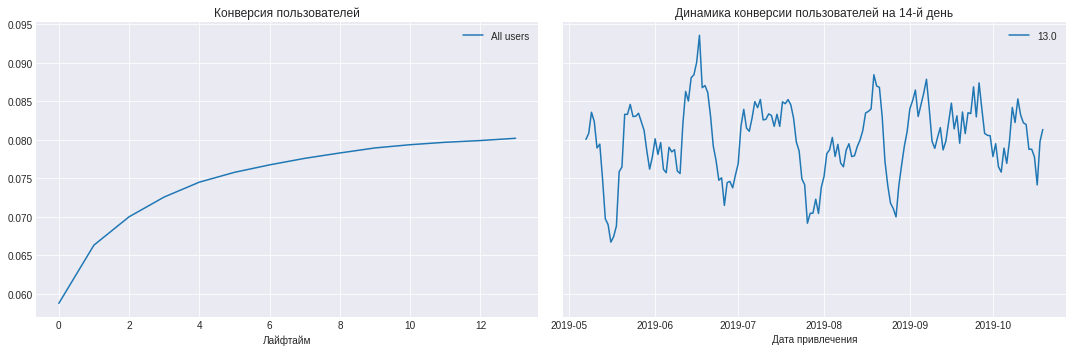

In [29]:
# получение сырых данных, таблицы конверсии, таблицы динамики конверсии
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

# визуализация кривой конверсии и динамики конверсии
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Кривая конверсии говорит о том, что пользователи хорошо и постоянно конвертируются, на конец второй недели конверсия составляет порядка 8 %. Согласно графику динамики конверсии пользователей отметим, что показатель не очень стабилен, т.к. кривая динамики шумная, лучше всего клиенты конвертировались в середине июня.

Также рассмотрим удержание пользователей и динамику его изменения. С помощью функции `get_retention()` получим таблицы удержания и его динамики. Визуализируем кривую удержания и его динамику вызовом функции `plot_retention()`.

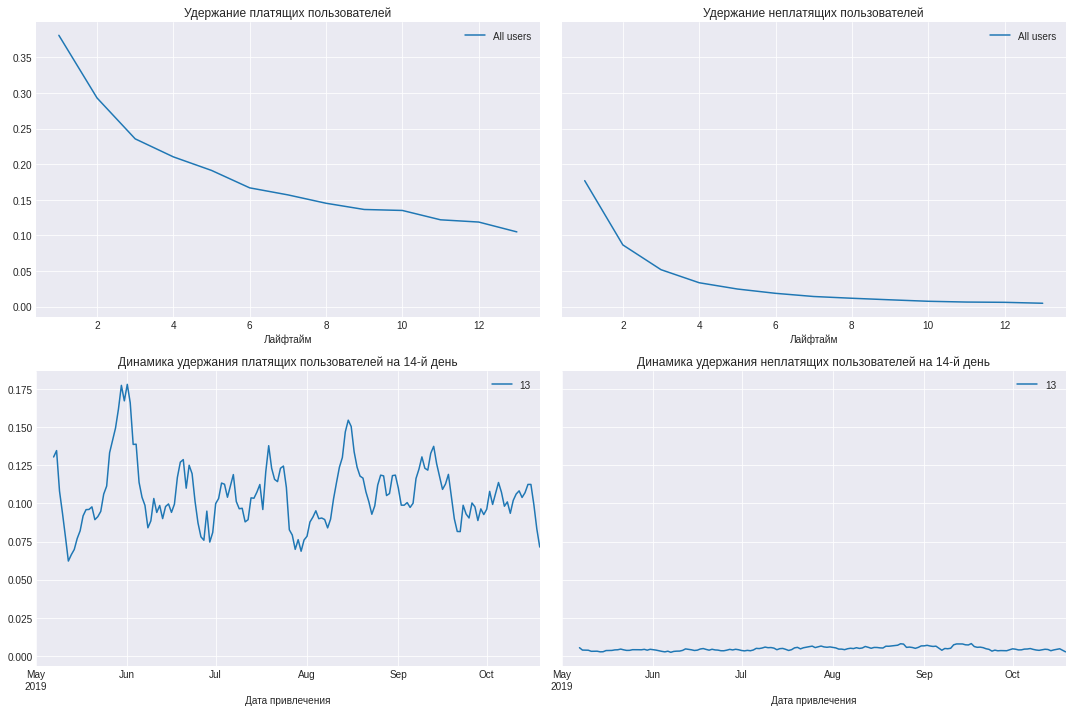

In [30]:
# получаем сырые данные, таблицу удержания и таблицу динамики удержания
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)

# строим кривые удержания платящих и неплатящих пользователей, графики динамики удержания платящих и неплатящих клиентов
plot_retention(retention_grouped, retention_history, horizon_days)    

Кривые удержания отражают стабильное снижение коэффициента удержания для всех пользователей. Платящих пользователей удается удерживать лучше, к концу второй недели порядка 10 % продолжают использовать приложение, в то время как удержание неплатящих стремится к нулю. Кривая динамики удержания платящих клиентов не отличается стабильностью, но не опускается ниже 6 %. Чаще всего пользоавтели возвращались в `Procrastinate Pro+` в конце мая - начале июня.

Пока мы не можем определить конкретные причины неэффективности маркетинга, поэтому продолжим анализ бизнес-показатлей в разрезе доступных характеристик пользователей — типа устройства, страны, канала привлечения.

#### Окупаемость рекламы с разбивкой по устройствам.

Проанализируем окупаемость рекламы с разбивкой по устройствам. Чтобы построить графики `LTV` и `ROI`, а также графики динамики `LTV`, `CAC` и `ROI` по каждому типу устройства, передадим `device` в качестве признака и вызовем последовательно функции `get_ltv()` и `plot_ltv_roi()`.

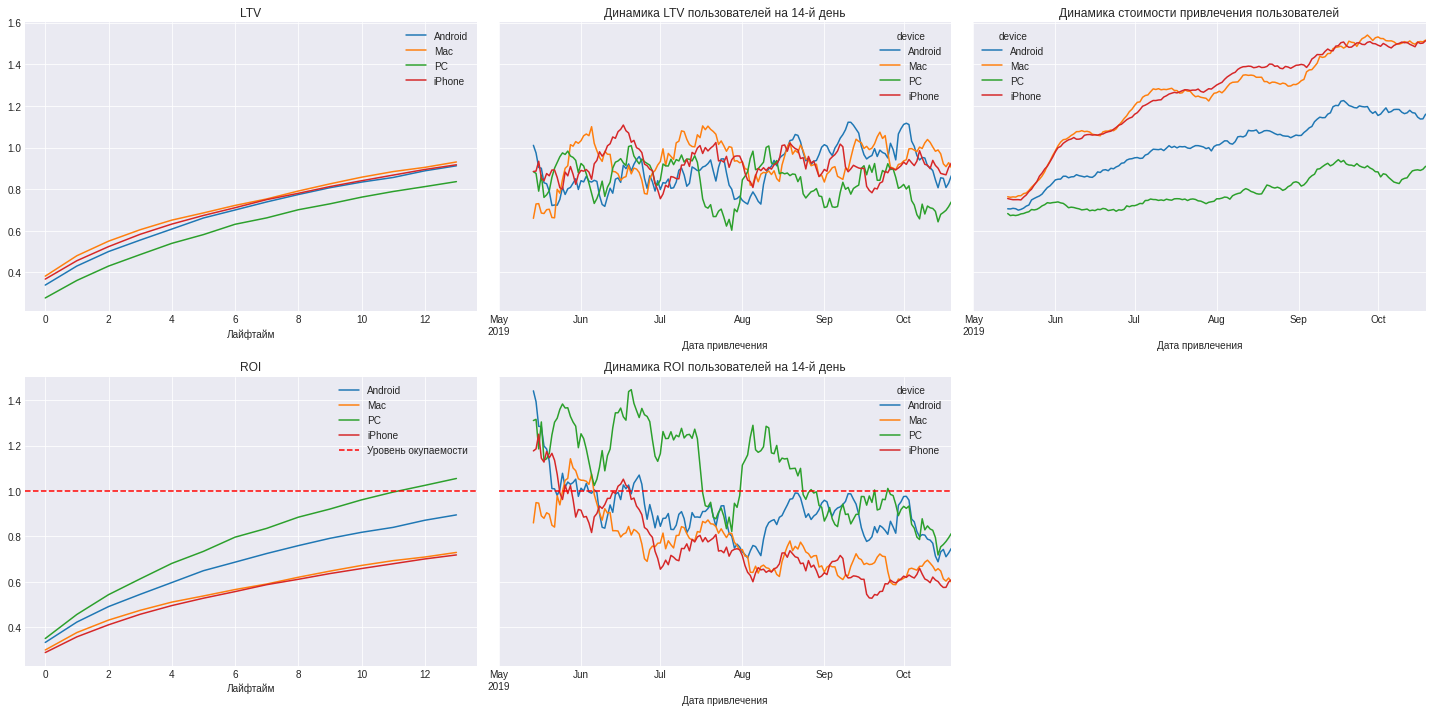

In [31]:
# добавление типа устройства клиента в качестве признака
dimensions = ['device']

# получение сырых данных, таблицы LTV, таблицы динамики LTV, таблицы ROI, таблицы динамики ROI с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

# визуализация кривых ltv, динамики ltv, динамики cac, кривых roi, динамики roi с разбивкой по устройствам
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Изучив графики, пришли к следующим выводам:

- LTV по всем устройствам относительно стабилен и увеличивается, однако доход от пользователей PC ниже.
- По кривым, отражающим динамику `CAC`, видим, что стоимость привлечения увеличивалась по всем устройствам. Меньше всего вкладывались в пользователей РС, а максимальные издержки по клиентам, использующим `Мас` и `iPhone`.
- Кривые `ROI` отражают, что реклама окупается только у пользователей `PC`. Наименьшая окупаемость у лидеров по величине `CAC`.
- Кривые динамики `ROI` всех устройств имеют общую тенденцию к снижению, но окупаемость пользователей PC выше других.

С учетом максимальных вливаний средств в пользователей `iPhone` и `Мас`, можем предполжить, что максимальная нацеленность маркетологов на американский рынок. Посчитаем бизнес-показатели по странам.

#### Окупаемость рекламы с разбивкой по странам.

Проанализируем окупаемость рекламы с разбивкой по странам. Чтобы построить графики `LTV` и `ROI`, а также графики динамики `LTV`, `CAC` и `ROI` по каждой стране, передадим `region` в качестве признака и вызовем последовательно функции `get_ltv()` и `plot_ltv_roi()`.

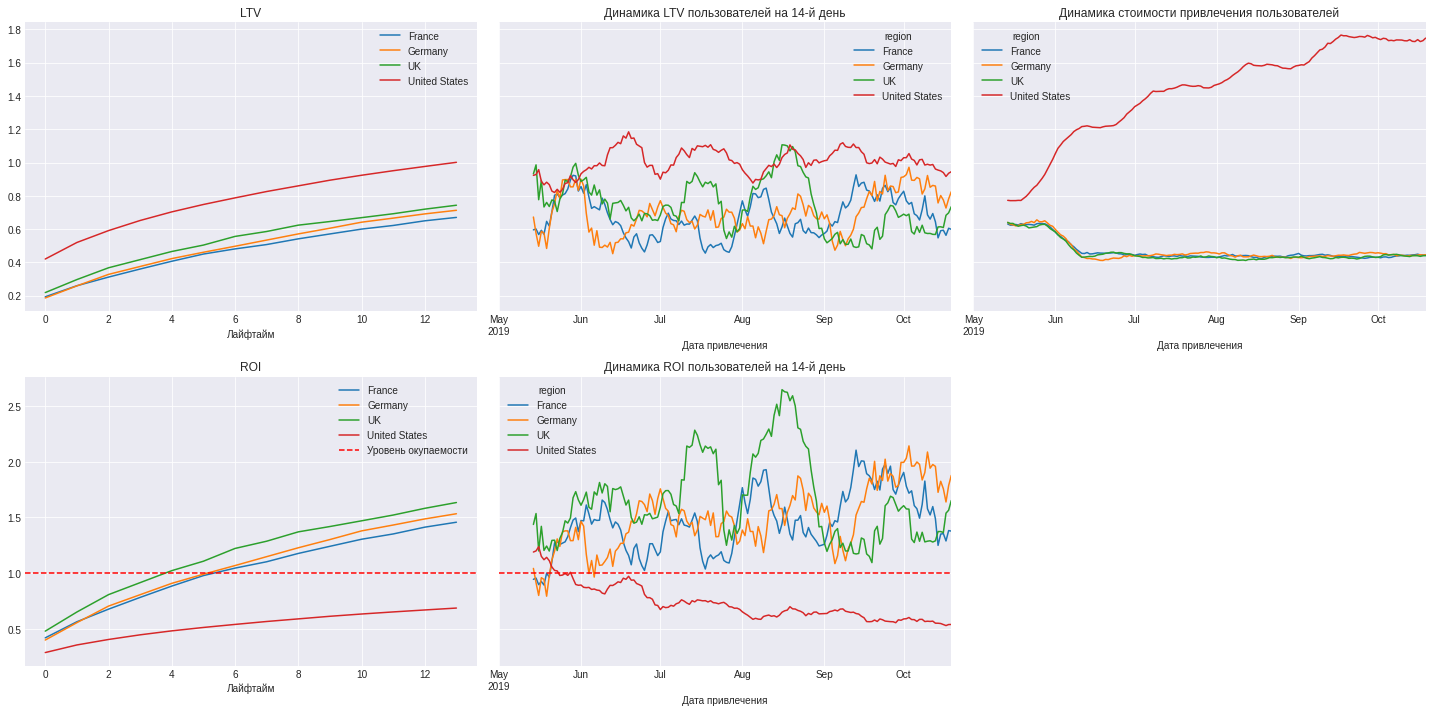

In [32]:
# добавление страны в качестве признака
dimensions = ['region']

# получение сырых данных, таблицы LTV, таблицы динамики LTV, таблицы ROI, таблицы динамики ROI с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

# визуализация кривых ltv, динамики ltv, динамики cac, кривых roi, динамики roi с разбивкой по странам
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Графики отражают интересные наблюдения:

- Максимальную выручку приложению приносят американские пользователи, `LTV` остальных стран стабилен и находится примерно на одном уровне.
- Подтверждается предположение о нацеленности на американский рынок, т.к. стоимость привлечения клиентов из других стран снизилась в июне и осталась на стабильно низком уровне. Чего нельзя сказать про США, `САС` американца постоянно увеличивался до сентября включительно и значительно превышет `LTV` страны.
- Кривые `ROI` подтверждают неэффективность маркетинга для американских пользователей.  Пользователи из Германии и Франции окупаются в 5-й лайфтам, выручка от французов чуть ниже. Небольшое преимущество по сроку и величине окупаемости рекламы для клиентов из Великобритании.
- Кривые динамики `ROI` также отражают неэффективность рекламы и снижение окупаемости для американцев, но подтверждают стабильную окупаемость маректинга для клиентов из других стран на 14-й день использования приложения.

#### Окупаемость рекламы с разбивкой по рекламным каналам.

Проанализируем окупаемость рекламы с разбивкой по каналам привлечения. Чтобы построить графики `LTV` и `ROI`, а также графики динамики `LTV`, `CAC` и `ROI` по каждому рекламному каналу, передадим `channel` в качестве признака и вызовем последовательно функции `get_ltv()` и `plot_ltv_roi()`.

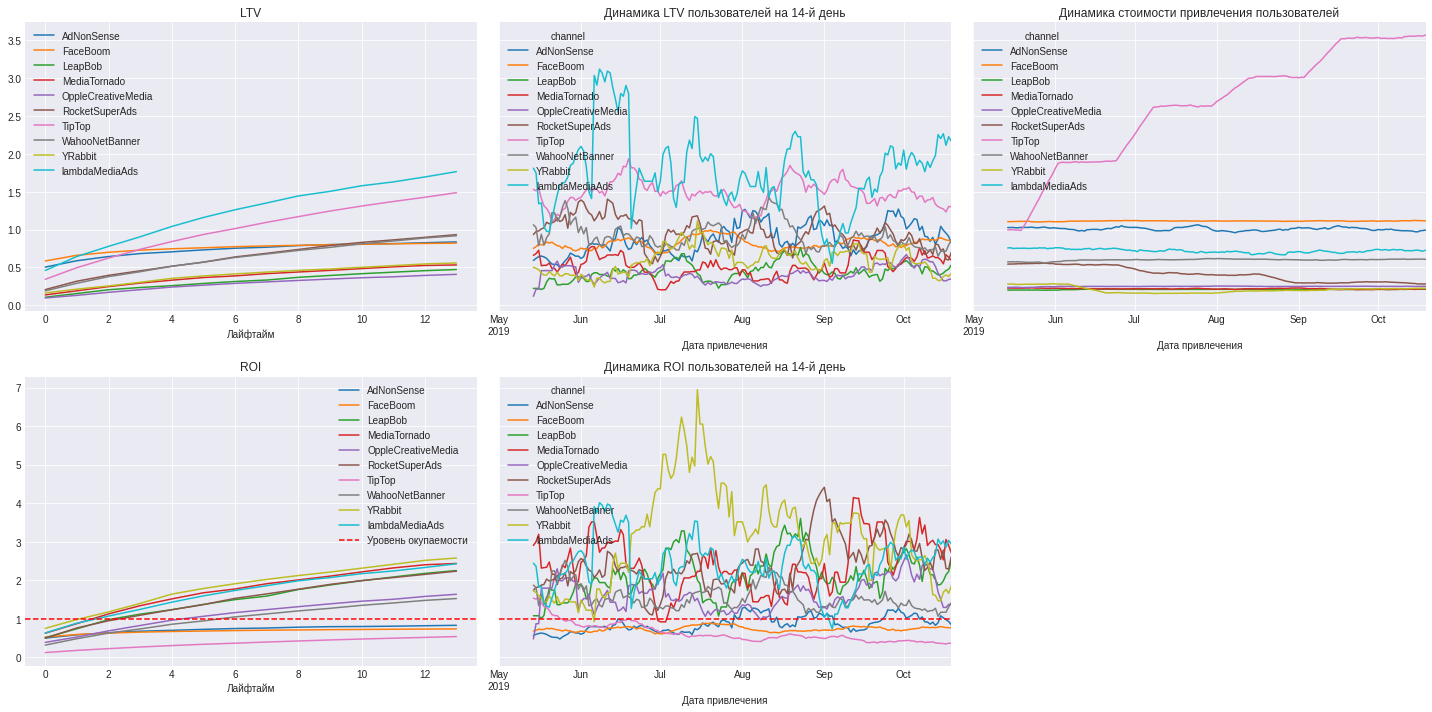

In [33]:
# добавление рекламного канала в качестве признака
dimensions = ['channel']

# получение сырых данных, таблицы LTV, таблицы динамики LTV, таблицы ROI, таблицы динамики ROI с разбивкой по каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

# визуализация кривых ltv, динамики ltv, динамики cac, кривых roi, динамики roi с разбивкой по каналам
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

По кривым `LTV`, `ROI`, их динамике и динамике `САС` отметим:

- Максимальную выручку приносят каналы `lambdaMediaAds` и `TipTop`.
- Динамика стоимости привлечения пользователей у `TipTop` сильно отличается, показатель резко увеличивается на протяжении всего исследуемого периода и превышает `LTV`.  У других каналов `CAC` практически не менялся.
- Кривые `ROI` демонстрируют окупаемость маркетинга для большей части каналов привлечения. Лучшая окупаемость у `YRabbit`, а минимальная - у `AdNonSense`, `FaceBoom` и `TipTop`, их маркетинг не окупается.

#### Конверсия и удержание пользователей c разбивкой по устройствам.

Проверим конверсию пользователей и динамику её изменения в разрезе типа устройства пользователя. Передадим `device` в качестве признака и вызовем последовательно функции `get_conversion()` и `plot_conversion()`.

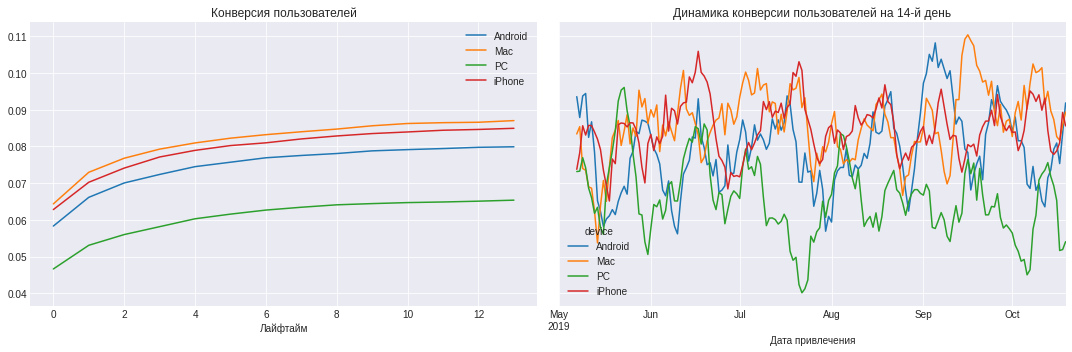

In [34]:
# добавление типа устройства клиента в качестве признака
dimensions = ['device']

# получение сырых данных, таблицы конверсии, таблицы динамики конверсии
conversion_raw, conversion_grouped, conversion_history = get_conversion(
profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# визуализация кривых конверсии и динамики конверсии
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи `МАС` и `iPhone` конвертируются лучше других, вероятно, неэффективность маркетинга связана с низким удержанием. У пользователей `РС` конверсия минимальная, но напомним, что это единственный тип устройства с окупаемой рекламой. Следовательно, удержание пользователей должно быть высоким. 

Проверим наши гипотезы и построим кривые удержания пользователей и динамику его изменения с разбивкой по типу устройства. Передадим параметру `dimensions` столбец `device` и поседовательно вызовем функции `get_retention()` и `plot_retention()`.

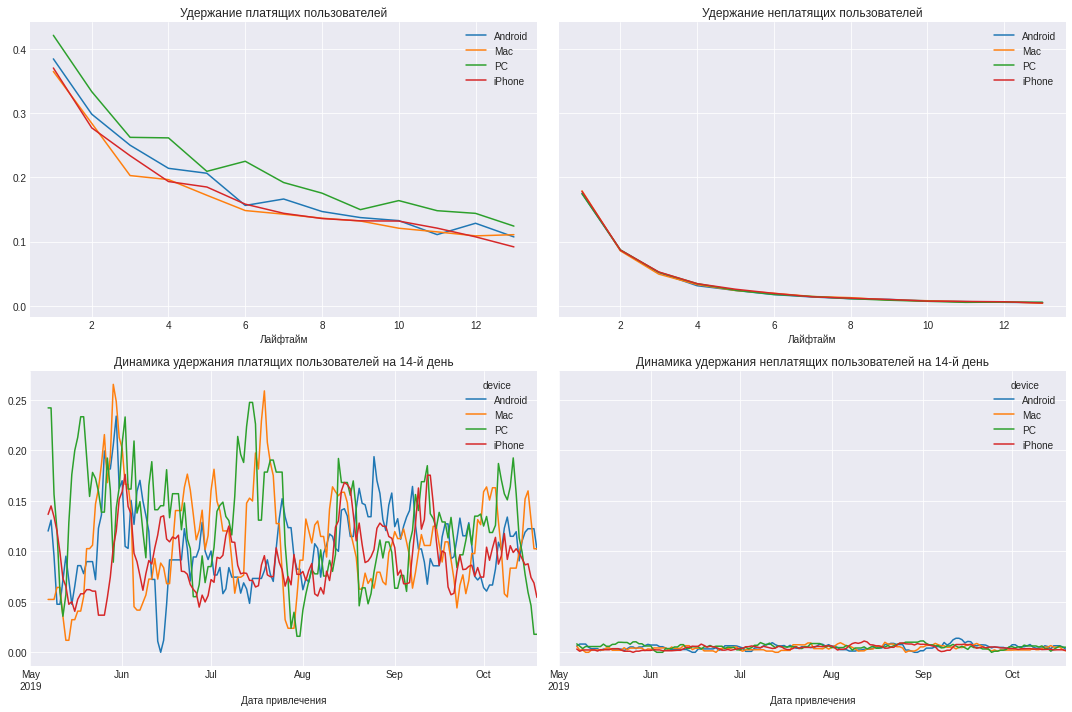

In [35]:
# добавление типа устройства клиента в качестве признака
dimensions = ['device']

# получаем сырые данные, таблицу удержания и таблицу динамики удержания
retention_raw, retention_grouped, retention_history = get_retention(
profiles, visits, observation_date, horizon_days, dimensions = dimensions)

# строим кривые удержания платящих и неплатящих пользователей, графики динамики удержания платящих и неплатящих клиентов
plot_retention(retention_grouped, retention_history, horizon_days)    

Действительно, платящие пользователи `МАС` и `iPhone` удерживаются несколько хуже, а лучшее удержание у `РС`. При этом график динамики удержания шумный, что говорит о нестабильности показателя. Неплатящие клиенты удерживаются одинаково плохо, вне зависимости от типа используемого устройства.

#### Конверсия и удержание пользователей c разбивкой по странам.

Проверим конверсию пользователей и динамику её изменения в разрезе стран. Передадим `region` в качестве признака и вызовем последовательно функции `get_conversion()` и `plot_conversion()`.

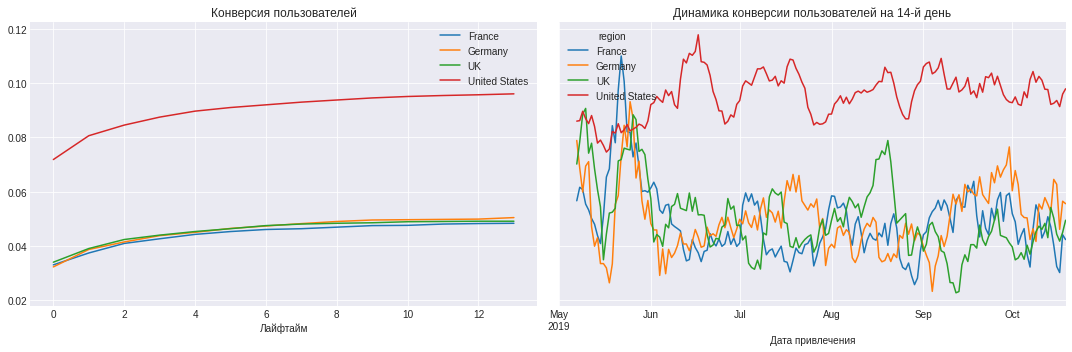

In [36]:
# добавление страны в качестве признака
dimensions = ['region']

# получение сырых данных, таблицы конверсии, таблицы динамики конверсии
conversion_raw, conversion_grouped, conversion_history = get_conversion(
profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# визуализация кривых конверсии и динамики конверсии
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Американцы конвертируются примерно вдвое лучше, чем пользователи других стран. Но с учетом того, что реклама для пользователей США не окупается, можно предположить, что удержание клиентов низкое. Проверим так ли это, и построим кривые удержания пользователей и динамику его изменения с разбивкой по странам. Передадим параметру `dimensions` столбец `region` и последовательно вызовем функции `get_retention()` и `plot_retention()`.

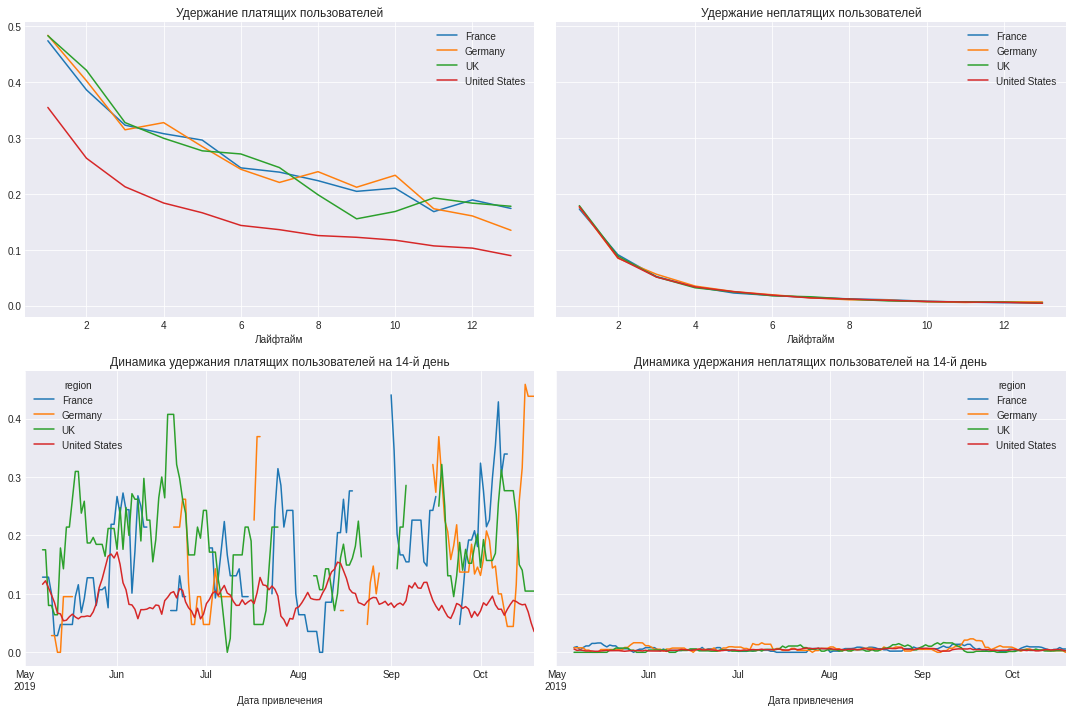

In [37]:
# добавление страны в качестве признака
dimensions = ['region']

# получаем сырые данные, таблицу удержания и таблицу динамики удержания
retention_raw, retention_grouped, retention_history = get_retention(
profiles, visits, observation_date, horizon_days, dimensions = dimensions)

# строим кривые удержания платящих и неплатящих пользователей, графики динамики удержания платящих и неплатящих клиентов
plot_retention(retention_grouped, retention_history, horizon_days)    

Гипотеза о слабом удержании американцев подтверждается, т.к. показатель стабильно низкий, следует подумать об оптимизации рекламы в этом регионе. В то время как удержание платящих пользователей других стран не отличается стабильностью, европейские клиенты удерживаются определенно лучше. Чего нельзя сказать об удержании неплатящих клиентов, к концу воторой недели единицы из представителей каждой страны продолжают использовать приложение.

#### Конверсия и удержание пользователей c разбивкой по рекламным каналам.

Проверим конверсию пользователей и динамику её изменения в разрезе источников привлечения. Передадим `channel` в качестве признака и вызовем последовательно функции `get_conversion()` и `plot_conversion()`.

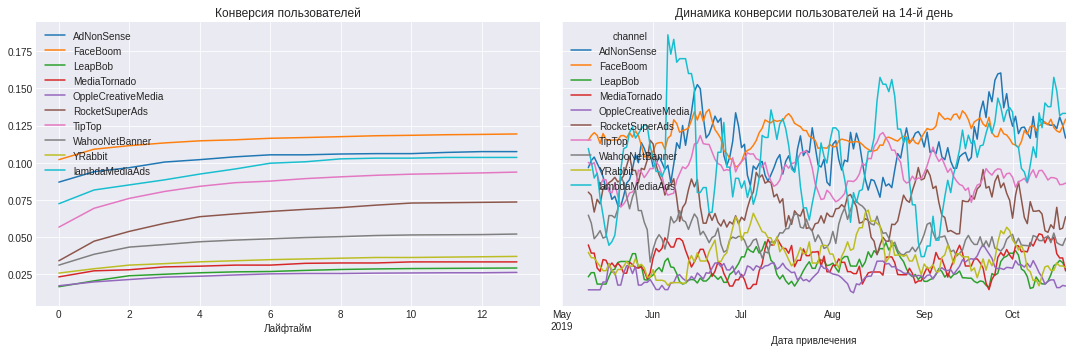

In [38]:
# добавление рекламного канала в качестве признака
dimensions = ['channel']

# получение сырых данных, таблицы конверсии, таблицы динамики конверсии
conversion_raw, conversion_grouped, conversion_history = get_conversion(
profiles, orders, observation_date, horizon_days, dimensions = dimensions)

# визуализация кривых конверсии и динамики конверсии
plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10)

Лучше всего пользователи конвертируются из каналов `FaceBoom`, `AdNonSense` и `lambdaMediaAds`. В целом клиенты хорошо конвертируются и по остальным источникам перехода, проверим как обстоят дела с удержанием клиентов. Скорее всего, удержание у `FaceBoom` и `AdNonSense` будет слабым, т.к. маркетинг данных каналов неэффективен. 

Отразим кривые удержания пользователей и динамику его изменения с разбивкой по рекламным каналам. Передадим параметру `dimensions` столбец `channel` и последовательно вызовем функции `get_retention()` и `plot_retention()`.

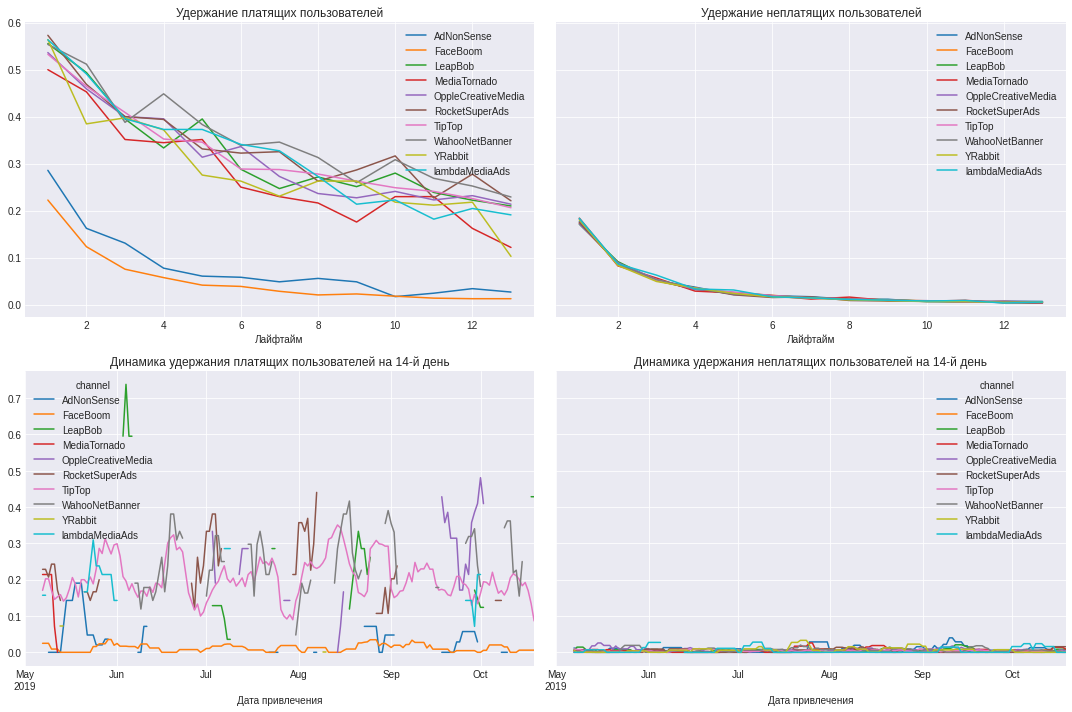

In [39]:
# добавление рекламного канала в качестве признака
dimensions = ['channel']

# получаем сырые данные, таблицу удержания и таблицу динамики удержания
retention_raw, retention_grouped, retention_history = get_retention(
profiles, visits, observation_date, horizon_days, dimensions = dimensions)

# строим кривые удержания платящих и неплатящих пользователей, графики динамики удержания платящих и неплатящих клиентов
plot_retention(retention_grouped, retention_history, horizon_days)  

Убедились, что предположение было верным, удержание платящих клиентов, привлеченных каналами `FaceBoom` и `AdNonSense` стабильно низкое, настолько, что совсем немного превосходит удержание неплатящих пользователей. Удержание платящего пользователя по остальным рекламным каналам не отличается стабильностью, но у значительной части источников перехода порядка 20% клиентов продолжают использовать приложение.

**Вывод**

Таким образом, используя графики `LTV`, `ROI` и `CAC`, а также кривые конверсии и удержания, оценили как общую окупаемость рекламы, так и ее эффективность с разбивкой по доступным характеристикам пользователей — типу устройства, стране, каналу привлечения.

В целом реклама, направленная на привлечение пользователей, не окупается. Несмотря на стабильность `LTV`, cтоимость привлечения пользователей постоянно увеличивается, в результате чего `CAC` превышает пожизненную ценность клиента. При подобных обстоятельствах компания несет убытки. Окупаемость рекламы снижается на протяжении всего периода исследования, и клиенты перестают окупаться уже в июне. К концу второй недели маркетинг окупается лишь на 80 %. При этом пользователи хорошо и постоянно конвертируются, на конец второй недели конверсия составляет порядка 8 %. Что касается удержания пользоватлей, то порядка 10 % продолжают использовать приложение `Procrastinate Pro+` на 14-й день.

К общим рекомендациям можно отнести снижение соимости привлечения клиента. Подобному снижению может способствовать оптимизация: ценообразования, расходов на рекламу, воронки продаж. Также стоит позаботиться об увеличении `LTV` путем оптимизации продукта, повышения лояльности пользователей или, к примеру, за счет увеличения среднего чека.

Проанализировав окупаемость рекламы с разбивкой по устройствам, странам и рекламным каналам, определили, что максимальные вложения в пользователей `iPhone` и `Мас` приводят к минимальной окупаемости рекламы. Несмотря на высокую конверсию американцев в пользователей, удерживаются они хуже европейцев. И США единственная страна, маркетинговые затраты которой, не окупаются. Также негативное влияние на окупаемость рекламы может оказывать рекламный канал `TipTop`. Стоимость привлечения пользователей у этого источника перехода сильно отличается от других каналов, показатель резко увеличивается на протяжении всего исследуемого периода и превышает `LTV`, в то время как `CAC` других каналов практически не менялся. Как следствие, минимальный показатель `ROI` и неэффективность рекламной кампании.

Проблемы окупаемости могут быть связаны как с неправильным распредлением средств, так и с технологическими факторами. Следует сократить маркетинговые затраты для устройств, стран и рекламных каналов, оказывающих негативное влияние на окупаемость рекламы. И напротив, увеличить вложения в перспективные рекламные кампании. Так, к примеру, имеет смысл привлекать пользователей `PC`, такие клиенты хорошо удерживаются, имеют минимальные расходы на привлечение и хорошо окупаются. Финансирование американского рынка следует перенаправить на европейский, т.к. при минимальных издержках компания может получить высокую окупаемость рекламной кампании. Также стоит обратить внимание на потенциально прибыльные каналы привлечения, советум рекламному отделу сократить затраты на `TipTop`, и присмотреться к каналу с лучшей окупаемостью рекламы, низкой стоимостью привлечения и хорошим удержанием клиентов - `YRabbit`.

### Общий вывод

Проводя исследовательскую работу на основе данных о визитах и заказах пользователей развлекательного приложения `Procrastinate Pro+`, привлечённых с 1 мая по 27 октября 2019 года, а также располагая информацией о рекламных расходах, изучили их и подготовили к анализу. Так, привели названия столбцов в соответсвие с хорошим стилем, а значения даты и времени - к соответсвующему типу данных. На этапе задания функций для расчёта и анализа `LTV`, `ROI`, удержания и конверсии собрали необходимые функции как для вычисления значений метрик, так и ряд функций для построения графиков. В ходе исследовательского анализа данных составили пользовательские профили и убедились в корректности временного диапазона привлечения клиентов, обозначенного в техническом задании. Определили, из каких стран приходят пользователи, и где платящих клиентов больше. Также исследовали распределения клиентов по типу устройства и рекламным каналам. На этапе анализа маркетинговых затрат посчитали общую сумму расходов на маркетинг и ознакомились с распределением трат по рекламным источникам. Также узнали, сколько в среднем стоило привлечение одного пользователя из каждого источника. Для анализа окупаемости рекламы использовали кривые `LTV`, `ROI` и `CAC`, а также графики конверсии и удержания, оценили как общую окупаемость рекламы, так и ее эффективность с разбивкой по доступным характеристикам пользователей — типу устройства, стране, каналу привлечения. В результате проведенного исследования пришли к следующим выводам:

- **распределение пользователей по странам:**

Пользователи приходят в приложение `Procrastinate Pro+` преимущественно из США, конверсия в платящих клиентов у этой страны также превосходит другие страны. Несмотря на минимальное количество клиентов из Германии, по доле платящих пользователей страна занимает второе место. Также пользователи приходят в приложение из Великобритании и Франции, доля платящих клиентов этих стран немного ниже.

- **распределение клиентов по типу устройства:**

Большая часть клиентов заходит с мобильных устройств, в частности с `iPhone`. Конверсия в платящих пользователей у данного типа устройства уступает лишь `Mac`, у которого число пользователей, напротив, минимальное. Также пользователи заходят в приложении с `Andriod` и `PC`, у которых доля платящих пользователей меньше.

- **распределение пользователей по каналам привлечения:**

Большая часть клиентов приходит естественным путем, но они реже становятся платящими. Наиболее популярными рекламными каналами являются `FaceBoom` и `TipTop`, конверсия в платящих клиентов данных источников высока. Также к лидерам по доле платящих пользователей отнесли `AdNonSense` и `lambdaMediaAds`, несмотря на минимальное количество пользователей. Возможно, имеет смысл обратить внимание на эти источники и увеличить размер рекламных бюджетов по ним.

- **анализ маркетинговых затрат:**

Общая сумма расходов на маркетинг приложения `Procrastinate Pro+` составила порядка 105,5 тысяч у.е. Максимальные рекламные затраты у каналов `TipTop` и `FaceBoom`, минимальные затраты на маркетинг у `MediaTornado` и `YRabbit`, они не превышают 1 тысячи у.е.. Динамика изменения расходов во времени отражает резкий рост затрат для канала `TipTop` с мая по сентябрь и плавное увеличение рекламных затрат источника `FaceBoom` с мая по август, у остальных каналов были незначительные измененния стоимости рекламного бюджета. У двух рекламных источников `FaceBoom` и `AdNonSense` расходы на привлечение клиента близки к среднему `САС` по всем рекламным каналам, равному 1.13 у.е. Затраты на привлечение пользователя из `TipTop` почти в 2,5 раза больше, а у остальных рекламных каналов, напротив, данный показатель значительно ниже.

- **общая окупаемость рекламы:**

Убедились в том, что несмотря на вложения в рекламу, компания терпит убытки. Несмотря на стабильность `LTV`, cтоимость привлечения пользователей постоянно увеличивается и превосходит размер выручки. Клиенты перестают окупаться уже в июне, и к концу второй недели маркетинг окупается лишь на 80 %. При этом клиенты неплохо и стабильно конвертируются и удерживаются, на конец второй недели конверсия составляет порядка 8 %, а удержание составляет около 10 %.

- **окупаемость рекламы с разбивкой по устройствам:**

Предполагаем, что маркетологи больше нацелены на американский рынок, т.к. максимально средства выделялись на пользователей `Мас` и `iPhone`. Подобные вложения неэффективны, потому что клиенты, ипользующие `iPhone` и `Мас`, удерживаются хуже других, и их рекламные кампании не окупаются. Реклама окупается только у пользователей PC, которые удерживаются лучше, но как раз в таких клиентов вкладывались меньше всего.

- **окупаемость рекламы с разбивкой по странам:**

Вновь убедились в приоритете американцев, стоимость привлечения которых постоянно увеличивалась до сентября включительно и значительно превышет `LTV` страны. Расходы на привлечение европейцев, напротив, снизились в июне и осталась на стабильно низком уровне. Клиенты из Великобритании окупаются на 5-й день, из Германии и Франции - на 6-й день, а американцы - плохо удерживаются и не окупаются. 

- **окупаемость рекламы с разбивкой по по рекламным каналам:**

Маркетологи постарались увеличить траффик канала `TipTop`, `СAC` которого резко увеличивается на протяжении всего исследуемого периода и превышает `LTV`, в то время как бюджет на привлечение клиентов из других каналов практически не менялся. Большинство источников перехода окупается, лучшая окупаемость у `YRabbit`, а минимальная - у `AdNonSense`, `FaceBoom` и `TipTop`, их маркетинг не окупается. Удержание клиентов, привлеченных каналами `FaceBoom` и `AdNonSense` стабильно низкое, а у значительной части источников перехода порядка 20 % клиентов продолжают использовать приложение. 

- **причины неэффективности привлечения пользователей:**

Неправильная расстановка приоритетов и как следствие неэффективное распределение средств привели компанию к финансовым потерям. 
Неоправданно завышенное финансирование для привлечения американцев, пользователей `iPhone` и `Мас`, а также развитие рекламного канала `TipTop` могут быть причинами убыточности маркетинговой кампании. Также неэффективность привлечения пользователей может быть спровоцирована техническими причинами, такими как лаги или ошибки при использовании приложения.

- **рекомендации для отдела маркетинга:**

Рекламному отделу следует сократить маркетинговые затраты для устройств, стран и рекламных каналов, оказывающих негативное влияние на окупаемость рекламы. И напротив, увеличить вложения в перспективные рекламные кампании. Имеет смысл сократить расходы на привлечение американцев и присмотреться к европейским пользователям, они неплохо удерживаются и окупаются. Что касается американцев, то следует разобраться, с чем связано низкое удержание клиентов, и провести работу над удержанием пользователей, ведь они составляют основную часть пользователей приложения. Если имеет место технологический фактор, то попытаться устранить его, если подобных проблем нет, то стоит продумать дополнительные меры по повышению лояльности пользователей (триал-версия, бесплатный тестовый период, демоверсии, бонусы, акции и скидки, подарки).

Рекомендуем привлекать пользователей `РС`, они лучше удерживаются и окупаются, а расходы на пользователей `iPhone` и `Мас` можно сократить, эти устройства без того приводят достаточное количество клиентов. Также стоит убедиться, не связана ли неэффективность маркетинга данных устройств с техническими причинами. Возможно, имеют место ошибки или лаги для этих платформ.

Что касается рекламных каналов, то маркетологам следует присмотреться к другим потенциально прибыльным каналам, к примеру - `YRabbit`. У данного источника перехода лучшая окупаемость, хорошее удержание клиентов, но как мы отметили ранее, компания практически не вкладывается в развите этого рекламного канала. Также для привлечения большего количества пользоваталей можно увеличить финансирование маркетинга для канала `lambdaMediaAds` с высокой долей платящих пользователей, который приносит максимальную выручку. Таким образом, стоит сократить финансирование дорогих каналов `TipTop` и `FaceBoom`, маркетинг которых не окупается, и начать развивать другие потенциально прибыльные рекламные каналы, такие как `TipTop` и `lambdaMediaAds`.